In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

%run ../setup.py

In [2]:
df = pd.read_csv('../../../../Dropbox (Sydney Uni)/Shared/pulsator_fraction/all_stars_with_gaia_mathur_green.csv')

In [3]:
puls = df[df['pulsating']==1]

In [4]:
puls['snrmed'].max()

1875.038162

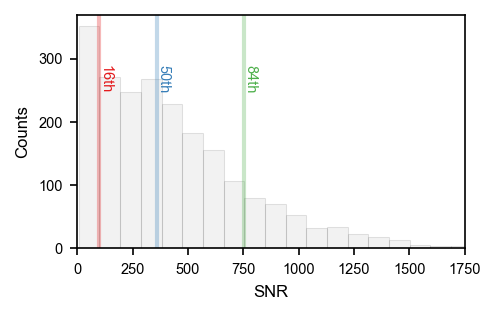

In [20]:
plt.figure(figsize=mnras_size(240.))

plt.hist(puls['snrmed'], bins=20, alpha=0.1, linewidth=0.5, edgecolor='black', color='gray')
# plt.hist(puls['snrmed'], bins=25, alpha=1, linewidth=0.5, color='k', histtype='step')

# n, bins, patches = plt.hist(puls['snrmed'], bins=20, histtype='step', linewidth=2, cumulative=True)

percs = np.percentile(puls['snrmed'], [15.87, 50, 84.13])
for perc, val, color in zip(percs, ['16th', '50th', '84th'], [red, blue,green]):
    plt.axvline(perc, c=color, linewidth=2, alpha=0.3)
    plt.text(perc, 250, val, rotation=-90, c=color, fontsize=7)

plt.xlabel('SNR')
plt.ylabel('Counts')
plt.xlim(0,1750)

plt.savefig(overleaf_path + 'snr_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('dsct_snr_dist.png', dpi=300, bbox_inches='tight')

Let's count the number of TESS CVZ stars with 2 min data

In [422]:
files = []
import glob

for sector in list(range(1,14)):
    files.extend(glob.glob('/Volumes/silo2/dhey3294/TESS/sector_' + str(sector) + '/tess*.fits'))

tics = [a.split('_')[1].split('/')[-1].split('-')[2].lstrip('0') for a in files]
unique_tics = np.unique(tics)

In [5]:
df = pd.read_csv('MAST queries/MAST_Crossmatch_TIC.csv', skiprows=4)
cut = (df['Teff'] > 6500) & (df['Teff'] < 10000)

unique_tics = df[cut]['target_name'].values

FileNotFoundError: [Errno 2] File b'MAST queries/MAST_Crossmatch_TIC.csv' does not exist: b'MAST queries/MAST_Crossmatch_TIC.csv'

In [259]:
from scipy.stats import skew

def dsct_search(unique_tic):
    try:
        unique_tic = str(unique_tic)
        indices = [i for i, x in enumerate(tics) if x == unique_tic]

        lc = lk.TessLightCurveFile(files[indices[0]]).PDCSAP_FLUX.normalize()
        for index in indices[1:]:
            lc = lc.append(lk.TessLightCurveFile(files[index]).PDCSAP_FLUX.normalize())
    except:
        return None
    lc = lc.remove_nans()
    pg = lc.to_periodogram(normalization='amplitude')#.plot()
    skewer = skew(pg.power.value[(pg.frequency.value > 20) & (pg.frequency.value < 100)])
    if skewer > 5:
        fig, axes = plt.subplots(3,1, figsize=[8,13])
        lc.plot(ax=axes[0])
        axes[1].plot(pg.frequency.value, pg.power.value, linewidth=0.7)
        axes[2].plot(pg.frequency.value, pg.power.value, linewidth=0.7)
        axes[2].set_xlim(0,100)
        plt.savefig('dSct search/' + unique_tic + '.png', bbox_inches='tight')
        plt.clf()
        plt.close(fig)
        return unique_tic, skewer, pg.power.value.max() / np.median(pg.power.value)
    else:
        return None

In [260]:
from tqdm import tqdm

dscts = []
for unique_tic in tqdm(unique_tics):
    dscts.append(dsct_search(unique_tic))



  0%|          | 0/794 [00:00<?, ?it/s]Warning: 31% (6168/19692) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


  0%|          | 1/794 [00:01<24:47,  1.88s/it]Warning: 31% (6168/19692) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/Users/danielhey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


  0%|          | 2/794 [00:05<33:06,  2.51s/it]Warning: 31% (6168/19692) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


  0%|          | 3/794 [00:07<30:30,  2.31s/it]Warning: 31% (6168/19692) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/Users/danielhey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


  1%|          | 4/794 [00:12<40:27,  3.07s/it]Warning: 31

In [309]:
np.savetxt('res.txt', res, fmt='%s')

In [6]:
res = np.loadtxt('res.txt')

(0, 1750)

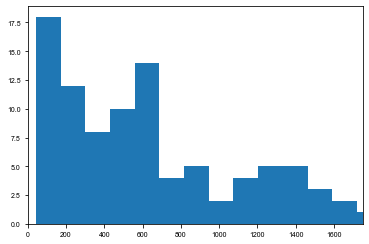

In [8]:
snrs = np.array(np.array(res)[:,2], dtype=float)
plt.hist(snrs[snrs<2000], bins=15);
plt.xlim(0,1750)

In [14]:
import seaborn as sns

In [21]:
sns.set_style('white')

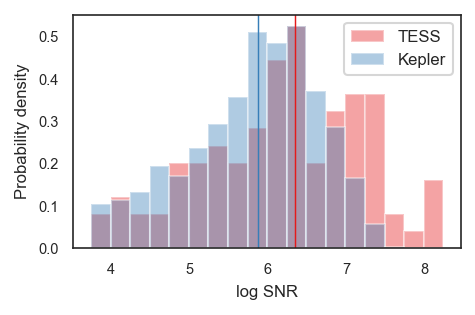

In [25]:
plt.figure(figsize=mnras_size(240.))

_, bins, _ = plt.hist(np.log(snrs), bins=18, alpha=0.4, density=True, color=red, label=r'TESS');
plt.hist(np.log(puls['snrmed']), bins=bins, alpha=0.4, color=blue, density=True, label=r'Kepler')
plt.xlabel('log SNR')
plt.ylabel('Probability density')
plt.legend()

plt.axvline(np.median(np.log(snrs)), c=red, linewidth=0.7)
plt.axvline(np.median(np.log(puls['snrmed'])), c=blue, linewidth=0.7)

plt.savefig(overleaf_path + 'dsct_tess_kepler_comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [430]:
df.iloc[0]#['Teff']

Column0               206
target_name      41030824
RA                90.4605
DEC              -71.9594
MatchID          41030824
                  ...    
Dec_orig          -71.959
e_RA_orig      0.00224736
e_Dec_orig     0.00229986
raddflag                1
wdflag                  0
Name: 0, Length: 129, dtype: object

In [431]:
result = Catalogs.query_criteria(catalog="Tic", ID=[41030824])
print(result)

   ID    version   HIP      TYC      ... raddflag wdflag   objID  
-------- -------- ----- ------------ ... -------- ------ ---------
41030824 20190415 28573 9172-00204-1 ...        1      0 557430368


In [432]:
result['Teff']

nan


In [88]:
import collections
counter=collections.Counter(tics)
#counter

In [148]:
keys = np.array(list(counter.keys()), dtype=str)
vals = np.array(list(counter.values()), dtype=int)

In [149]:
cvz_tics = keys[vals > 10]

In [150]:
np.savetxt('cvz_tics.csv', cvz_tics, delimiter=',', fmt="%s")

In [151]:
len(cvz_tics), len(unique_tics)

(5153, 128246)

In [152]:
df = pd.read_csv('MAST queries/MAST_2019-10-10T0122.csv', skiprows=4, dtype={'target_name':str})
cut_df = df.drop_duplicates(subset=['target_name'], keep='first')

In [153]:
final_cvz_tic = []
for cvz_tic in cvz_tics:
    final_cvz_tic.append(cvz_tic.lstrip('0'))
    
final_cvz_tic = np.array(final_cvz_tic, dtype=str)

In [169]:
tic_tic = cut_df[['target_name', 's_ra','s_dec']]
tic_tic.to_csv('MAST queries/all_TIC_id_and_positions.csv')

In [170]:
tic_tic.iloc[0]['target_name']

'152475412'

In [171]:
tic_tic

,target_name,s_ra,s_dec
0,152475412,62.472100,-44.614000
1,149630754,87.560639,-60.692772
2,274088693,49.537700,1.398700
3,441512021,48.404271,-13.639393
4,294272049,108.407187,-58.145135
...,...,...,...
296098,262616667,264.463440,-37.861403
296102,176463726,235.684967,-36.503738
296103,68255976,243.045902,-28.303567
296106,254328015,234.698744,-43.514609


In [172]:
final_cvz_tic

array(['141755414', '141944488', '140599471', ..., '294782174',
       '350842838', '358154471'], dtype='<U9')

In [176]:
tic_tic[tic_tic.target_name.isin(final_cvz_tic)]#.to_csv('tic_cvz_target_names.csv')

,target_name,s_ra,s_dec
1,149630754,87.560639,-60.692772
4,294272049,108.407187,-58.145135
7,294328148,108.854887,-59.546021
14,38711529,67.050085,-60.359424
15,350652586,87.785121,-55.423162
...,...,...,...
73743,179305059,79.676679,-69.236305
74147,278988794,101.902407,-57.824760
74320,179308923,79.824084,-69.653946
75113,55848818,75.831115,-62.198113


In [266]:
cleaned = [x for x in dscts if str(x) != None]
cleaned = np.array(cleaned)

In [280]:
np.array(dscts)[:]

'167602316'

In [189]:

df[cut].to_csv('MAST queries/dsct_cvz.csv')

Text(0, 0.5, 'Counts')

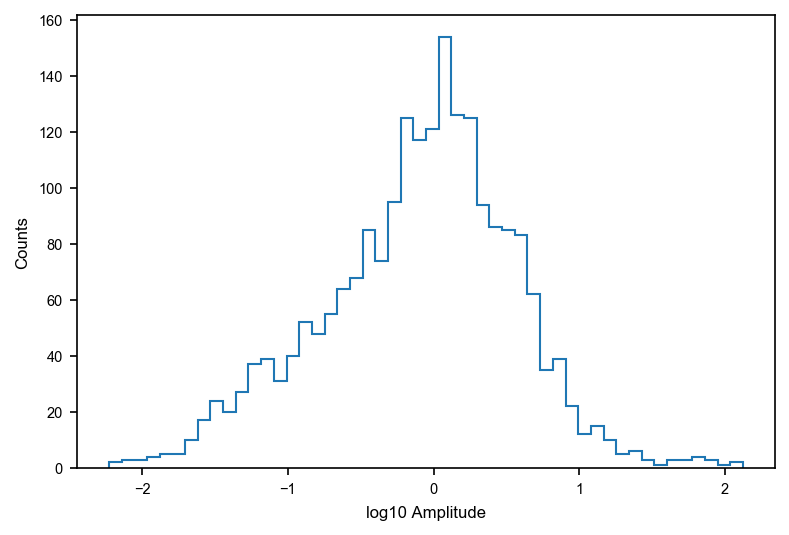

In [409]:
plt.hist(np.log10(df[df['pulsating']==1]['amp'] * 0.835), bins=50, histtype='step')
plt.xlabel('log10 Amplitude')
plt.ylabel('Counts')
# plt.savefig('amplitude.png', dpi=300)

Text(0, 0.5, 'Counts')

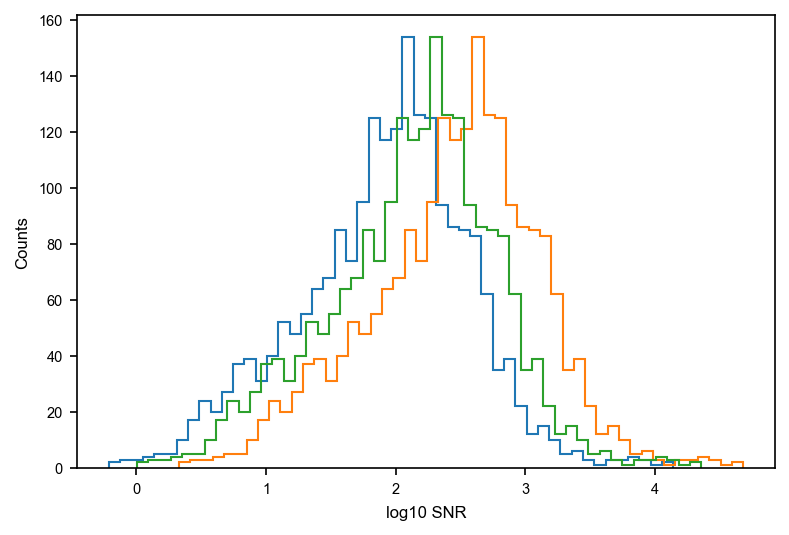

In [410]:
vals = (df[df['pulsating']==1]['amp'] * 0.835 * 1e-3)# / np.mean(a)
plt.hist(np.log10(vals / 9.640536450211061e-06), bins=50, histtype='step')
plt.hist(np.log10(vals / 2.790775897053371e-06), bins=50, histtype='step')
plt.hist(np.log10(vals / 5.86e-06), bins=50, histtype='step')
plt.xlabel('log10 SNR')
plt.ylabel('Counts')

# plt.savefig('amplitude.png', dpi=300)

In [411]:
import pandas as pd

df = pd.read_csv('../data/rev_AF_stars.csv')
df = df[df['loglbol_g_median'] < 2.1]

In [412]:
df['loglbol_g_median']

0        0.941
1        0.750
2        0.665
3        0.907
4        1.143
         ...  
14325    0.861
14326    1.165
14327    1.587
14328    0.914
14329    0.801
Name: loglbol_g_median, Length: 14258, dtype: float64

In [358]:
mast_stars = pd.read_csv('../data/MAST_Crossmatch_TIC.csv', skiprows=4)
result_df = mast_stars.drop_duplicates(subset=['target_name'], keep='first')
cut = (result_df['Teff'] < 10000) & (result_df['Teff'] > 6500)
result_df = result_df[cut]

(6500, 10000)

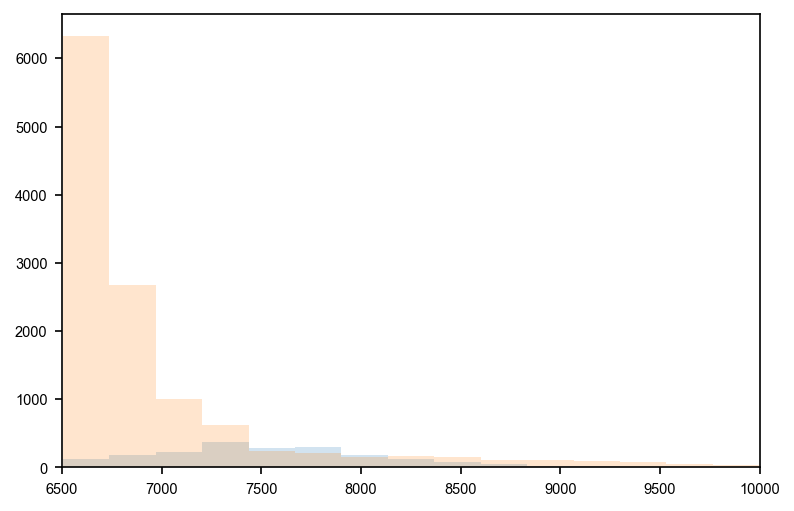

In [413]:
n_dsct_teff, bins_dsct_teff, _ = plt.hist(df[df['dSct'] == 1]['Teffi'], bins=15, alpha=0.2, label='Kepler dSct')
n_nonpuls_teff, _, _ = plt.hist(df[df['dSct'] == 0]['Teffi'], bins=bins_dsct_teff, alpha=0.2, label='Kepler non dSct')
# plt.hist(result_df['Teff'], bins=binsdsct, alpha=0.2,  density=True, label='TESS CVZ')
plt.xlim(6500, 10000)


(10000, 6500)

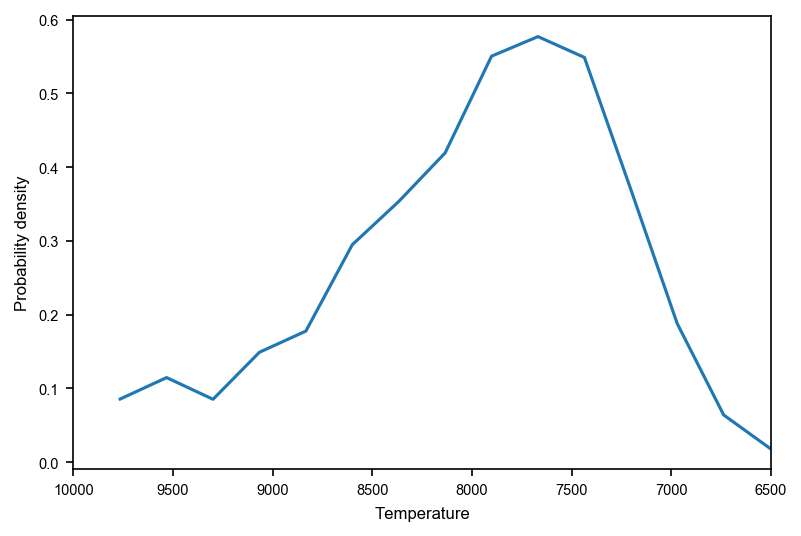

In [414]:
prob_teff = n_dsct_teff / (n_nonpuls_teff + n_dsct_teff)
plt.plot(bins_dsct_teff[:-1], prob_teff)
plt.xlabel('Temperature')
plt.ylabel('Probability density')
plt.xlim(10000,6500)

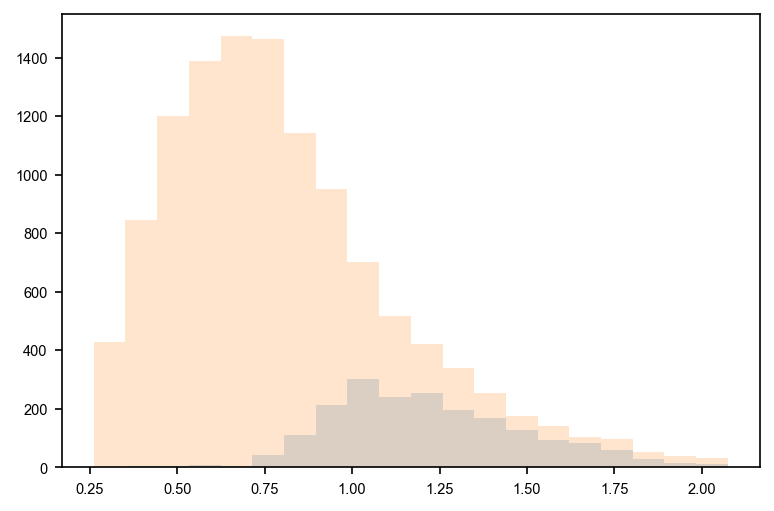

In [415]:
n_dsct_lum, bins_dsct_lum, _ = plt.hist(df[df['dSct'] == 1]['loglbol_g_median'], bins=20, alpha=0.2, label='Kepler dSct')
n_nonpuls_lum, _, _ = plt.hist(df[df['dSct'] == 0]['loglbol_g_median'], bins=bins_dsct_lum, alpha=0.2, label='Kepler non dSct')

Text(0, 0.5, 'Probability density')

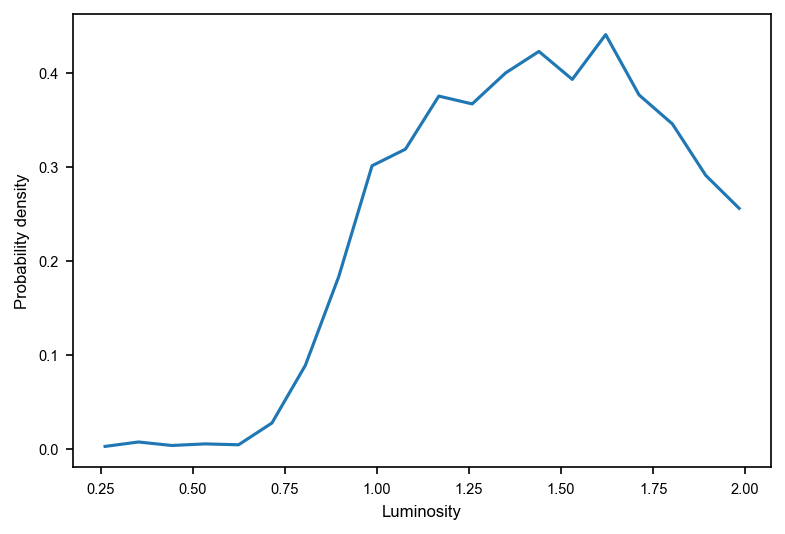

In [416]:
prob_lum = n_dsct_lum / (n_nonpuls_lum + n_dsct_lum)
plt.plot(bins_dsct_lum[:-1], prob_lum)
plt.xlabel('Luminosity')
plt.ylabel('Probability density')

In [417]:
np.random.rand()

0.3809186287392239

In [371]:
for index, row in df2:
    

,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,...,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag
104,science,TESS,SPOC,Photometer,TESS,TESS,Optical,418249584,NaN,tess2019140104343-s0012-0000000418249584-0144-s,...,tycho2b3,NaN,70.000000,250.000000,196.064846,-80.219131,70.000000,250.000000,-1,0
310,science,TESS,SPOC,Photometer,TESS,TESS,Optical,384739873,NaN,tess2019169103026-s0013-0000000384739873-0146-s,...,tycho2b3,NaN,0.226334,0.225289,258.826996,-78.398962,0.226334,0.225289,-1,0
332,science,TESS,SPOC,Photometer,TESS,TESS,Optical,383381570,NaN,tess2019140104343-s0012-0000000383381570-0144-s,...,tycho2b3,NaN,0.922706,0.623908,190.549315,-88.236594,0.022480,0.021633,1,0
340,science,TESS,SPOC,Photometer,TESS,TESS,Optical,468158572,NaN,tess2019140104343-s0012-0000000468158572-0144-s,...,tycho2b3,NaN,1.102627,0.972438,310.960769,-86.287471,0.025420,0.032677,1,0
347,science,TESS,SPOC,Photometer,TESS,TESS,Optical,267166371,NaN,tess2019140104343-s0012-0000000267166371-0144-s,...,tycho2b3,NaN,2.948983,1.862978,50.055407,-85.582158,0.081475,0.063176,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,science,TESS,SPOC,Photometer,TESS,TESS,Optical,267168108,NaN,tess2019169103026-s0013-0000000267168108-0146-s,...,tycho2b3,NaN,1.068176,0.675697,51.416899,-85.946162,0.025728,0.020846,1,0
9874,science,TESS,SPOC,Photometer,TESS,TESS,Optical,257608273,NaN,tess2019169103026-s0013-0000000257608273-0146-s,...,tycho2b3,NaN,2.449995,2.033165,292.557993,-80.906304,0.061422,0.069621,1,0
9878,science,TESS,SPOC,Photometer,TESS,TESS,Optical,309484693,NaN,tess2019112060037-s0011-0000000309484693-0143-s,...,tycho2b3,NaN,0.358611,0.394025,139.473396,-78.428436,0.358611,0.394025,-1,-1
9911,science,TESS,SPOC,Photometer,TESS,TESS,Optical,346703648,NaN,tess2019169103026-s0013-0000000346703648-0146-s,...,tycho2b3,NaN,0.961996,1.000262,296.891968,-78.142666,0.023859,0.034644,1,0


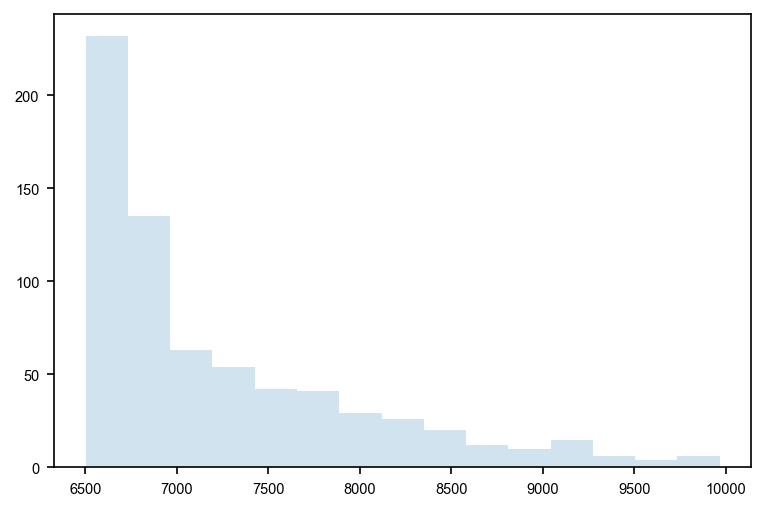

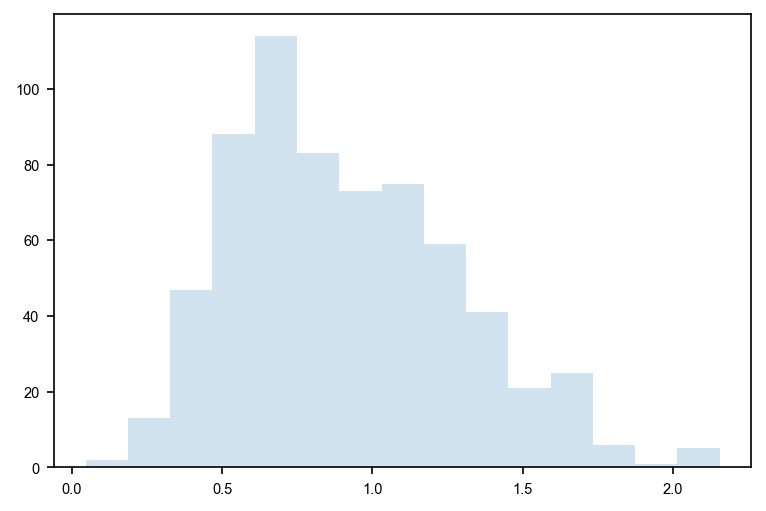

In [364]:
plt.hist(result_df['Teff'], bins=15, alpha=0.2,  density=False, label='TESS CVZ');
plt.show()
plt.hist(np.log10(result_df['lum']), bins=15, alpha=0.2,  density=False, label='TESS CVZ');

(10000, 6500)

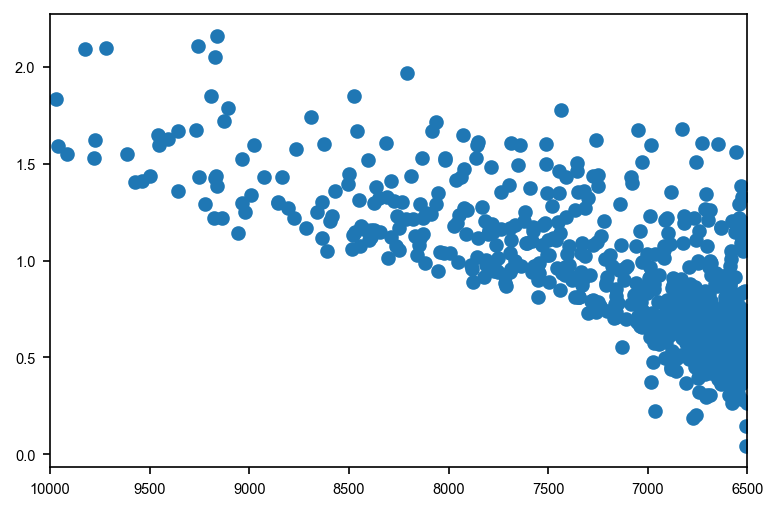

In [167]:
plt.scatter(result_df['Teff'], np.log10(result_df['lum']))
plt.xlim(10000,6500)


In [343]:
from astroquery.mast import Catalogs

tids = ['2760710','9006668','9725627','9727392',
            '12421862','12423815']
result = Catalogs.query_criteria(catalog="Tic", ID=tids)
print(result)

   ID    version  HIP     TYC      ... raddflag wdflag   objID   
-------- -------- --- ------------ ... -------- ------ ----------
 2760710 20190415  --           -- ...        1      0 1726777261
 9006668 20190415  -- 6398-00132-1 ...        1      0 1725120861
 9725627 20190415  -- 5834-00095-1 ...        1      0 1727228823
 9727392 20190415  --           -- ...        1      0 1727230588
12421862 20190415 738 6415-01134-1 ...        1      0  508792137
12423815 20190415  --           -- ...        1      0  508794090
